In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import gc

In [2]:
test_df = pd.read_csv('datasets/test.csv.gz')
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [3]:
item_df = pd.read_csv('datasets/items.csv')
item_df

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [4]:
sales_df = pd.read_csv('datasets/sales_train.csv.gz')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%d.%m.%Y')
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [5]:
sales_df.isna().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='date'>

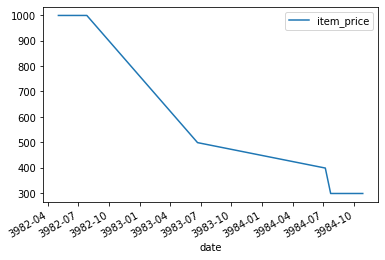

In [6]:
sample_item = sales_df.sample(1, random_state=123)
shop_id = sample_item['shop_id'].values[0]
item_id = sample_item['item_id'].values[0]
item_sales_df = sales_df[(sales_df['shop_id'] == shop_id) & (sales_df['item_id'] == item_id)].sort_values('date')
item_sales_df.plot(x='date', y='item_price')

In [7]:
monthly_sales_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False) \
                            .agg({'item_price': 'mean', 'item_cnt_day': 'sum'})
monthly_sales_df.rename(columns={'item_cnt_day': 'count'}, inplace=True)
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count
0,0,30,1,265.0,31.0
1,0,31,1,434.0,11.0
2,0,32,0,221.0,6.0
3,0,32,1,221.0,10.0
4,0,33,0,347.0,3.0
...,...,...,...,...,...
1609119,59,22164,27,699.0,2.0
1609120,59,22164,30,699.0,1.0
1609121,59,22167,9,299.0,1.0
1609122,59,22167,11,299.0,2.0


<AxesSubplot:xlabel='item_price', ylabel='count'>

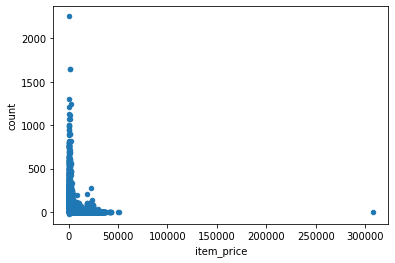

In [8]:
# prices = resampled_sales_df['item_price']
# counts = resampled_sales_df['item_cnt_day']

# resampled_sales_df = resampled_sales_df[((prices > prices.quantile(0.01)) & (prices < prices.quantile(0.99))) &
#                                         ((counts > counts.quantile(0.01)) & (counts < counts.quantile(0.99)))]
monthly_sales_df.plot.scatter(x='item_price', y='count')

In [9]:
monthly_sales_df.describe()

,shop_id,item_id,date_block_num,item_price,count
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,3.280585e+01,1.068099e+04,1.466479e+01,7.908847e+02,2.267200e+00
std,1.653701e+01,6.238883e+03,9.542322e+00,1.551605e+03,8.649882e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01
25%,2.100000e+01,5.045000e+03,6.000000e+00,1.990000e+02,1.000000e+00
50%,3.100000e+01,1.049700e+04,1.400000e+01,3.990000e+02,1.000000e+00
75%,4.700000e+01,1.606000e+04,2.300000e+01,8.985000e+02,2.000000e+00
max,5.900000e+01,2.216900e+04,3.300000e+01,3.079800e+05,2.253000e+03


### Prove the sales of any shop are different and unique

Text(0, 0.5, 'item_count')

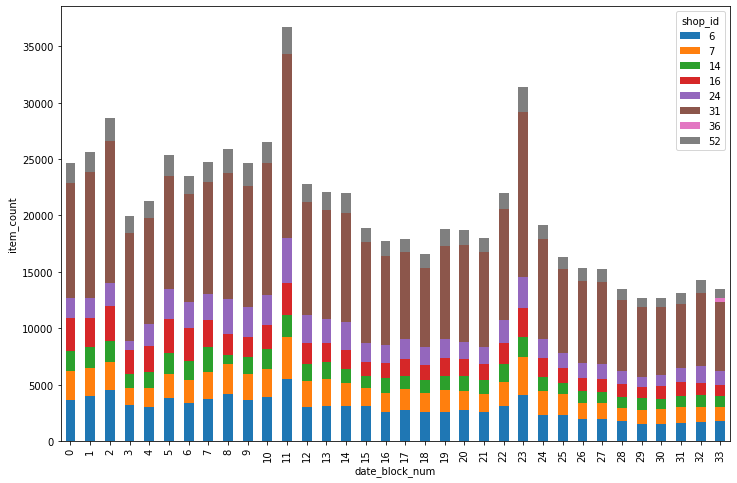

In [10]:
shop_ids = monthly_sales_df['shop_id']
selected_shop_ids = shop_ids.drop_duplicates().sample(8, random_state=99)

ax = monthly_sales_df[shop_ids.isin(selected_shop_ids)].groupby(['date_block_num', 'shop_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))
ax.set_ylabel('item_count')

### Prove the sales of any item categories are different

In [11]:
monthly_sales_df = monthly_sales_df.merge(item_df[['item_id', 'item_category_id']], on='item_id')
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,31.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


<AxesSubplot:xlabel='date_block_num'>

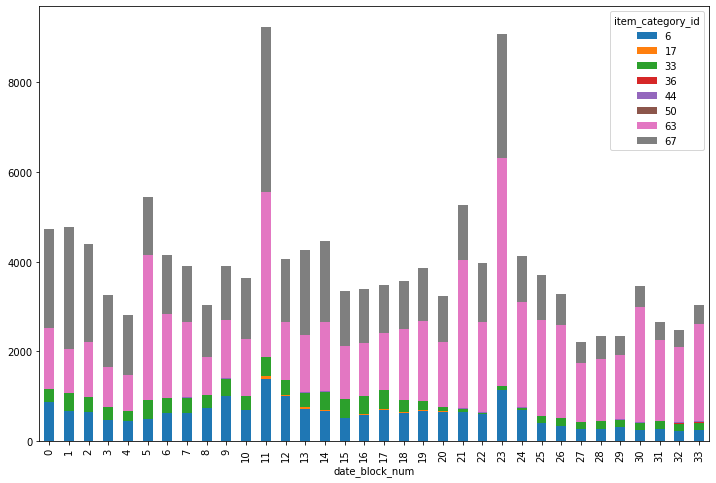

In [12]:
categories = monthly_sales_df['item_category_id']
selected_categories = categories.drop_duplicates().sample(8, random_state=1)
monthly_sales_df[categories.isin(selected_categories)].groupby(['date_block_num', 'item_category_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))

### Distribution

In [13]:
def IQR(data, lower, upper):
    return data[(data > data.quantile(lower)) & (data < data.quantile(upper))]


<AxesSubplot:>

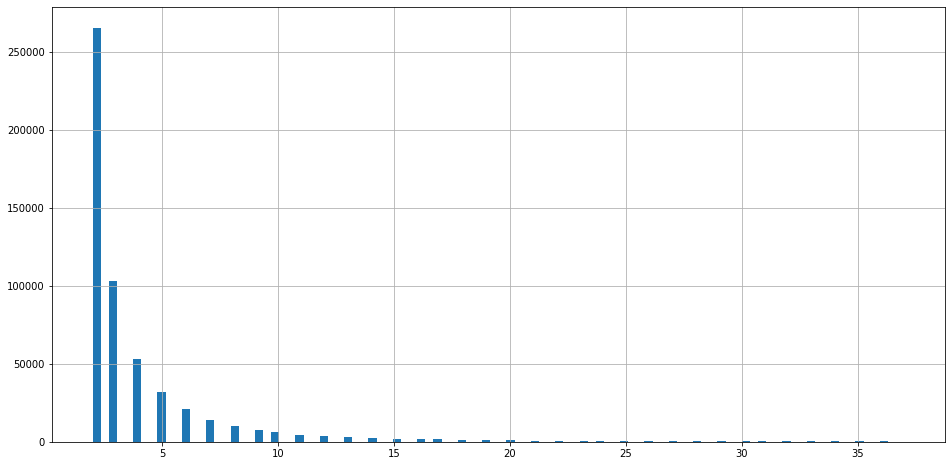

In [14]:
alpha = 0.0027
IQR(monthly_sales_df['count'], alpha, 1-alpha).hist(bins=100, figsize=(16, 8))

<AxesSubplot:>

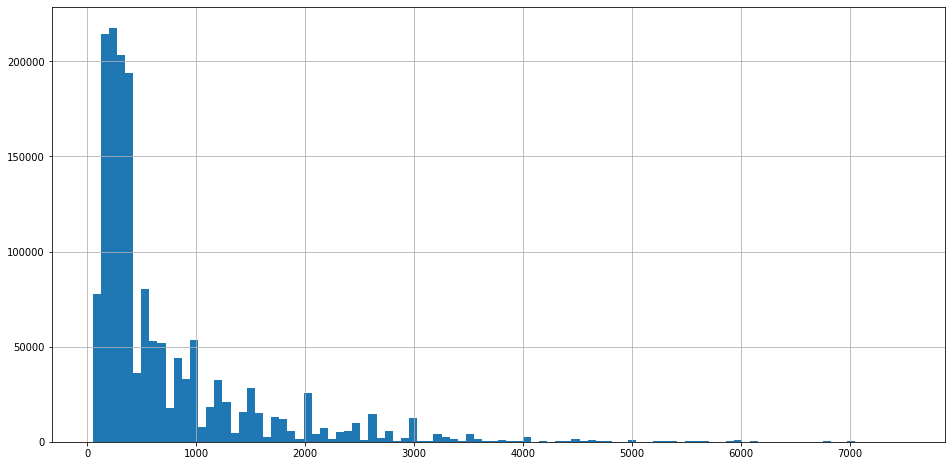

In [15]:
alpha = 0.008
IQR(monthly_sales_df['item_price'], alpha, 1-alpha).hist( bins=100, figsize=(16, 8))

In [16]:
monthly_sales_df.set_index(['shop_id', 'item_id', 'date_block_num']).head(20)

item_price  count  item_category_id
shop_id item_id date_block_num                                     
0       30      1                    265.0   31.0                40
1       30      1                    265.0   10.0                40
2       30      2                    359.0    1.0                40
                5                    399.0    1.0                40
                15                   169.0    1.0                40
                16                   169.0    1.0                40
3       30      1                    399.0    4.0                40
                2                    399.0    5.0                40
                3                    399.0    2.0                40
                4                    399.0    2.0                40
                5                    399.0    1.0                40
                9                    169.0    1.0                40
                10                   169.0    1.0                40
                11                   169.0    2.0                40
                12                   169.0    1.0                40
                30                   129.0    1.0                40
4       30      1                    399.0    7.0                40
                2                    399.0    3.0                40
                7                    399.0    1.0                40
5       30      1                    399.0    5.0                40

In [17]:
monthly_sales_df.nunique()

shop_id                60
item_id             21807
date_block_num         34
item_price          41464
count                 446
item_category_id       84
dtype: int64

In [18]:
test_df.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [19]:
gc.collect()

100

### Drop out-of-test row

In [20]:
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,31.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


In [21]:
selected_shop = monthly_sales_df['shop_id'].isin(test_df['shop_id'])
selected_item = monthly_sales_df['item_id'].isin(test_df['item_id'])
monthly_sales_df = monthly_sales_df[selected_shop & selected_item]
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
5,2,30,16,169.0,1.0,40
6,3,30,1,399.0,4.0,40
...,...,...,...,...,...,...
1609052,55,22166,31,150.0,11.0,54
1609053,55,22166,32,150.0,5.0,54
1609054,55,22166,33,150.0,11.0,54
1609096,57,15925,33,11899.0,1.0,72


In [22]:
_monthly_sales_df = monthly_sales_df.copy()

In [23]:
_monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
5,2,30,16,169.0,1.0,40
6,3,30,1,399.0,4.0,40
...,...,...,...,...,...,...
1609052,55,22166,31,150.0,11.0,54
1609053,55,22166,32,150.0,5.0,54
1609054,55,22166,33,150.0,11.0,54
1609096,57,15925,33,11899.0,1.0,72


## Feature Engineering

In [24]:
def generate_feature(df, by, base_col, output_col, agg_func):
    agg_df = df.groupby(by, as_index=False).agg({base_col: agg_func})
    agg_df.rename(columns={base_col: output_col}, inplace=True)
    return df.merge(agg_df, how='left', on=by)

In [123]:
monthly_sales_df = _monthly_sales_df.copy()
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'shop_id', 'date_block_num'], base_col='count', output_col='count_by_shop', agg_func='sum')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_id', 'date_block_num'], base_col='count', output_col='count_by_item', agg_func='sum')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_category_id', 'date_block_num'], base_col='count', output_col='count_by_item_cat', agg_func='sum')

monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'shop_id', 'date_block_num'], base_col='item_price', output_col='avg_shop_price', agg_func='mean')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_id', 'date_block_num'], base_col='item_price', output_col='avg_item_price', agg_func='mean')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_category_id', 'date_block_num'], base_col='item_price', output_col='avg_item_cat_price', agg_func='mean')
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price
0,2,30,2,359.0,1.0,40,237.0,394.0,3361.0,961.593339,393.876797,217.173918
1,2,30,5,399.0,1.0,40,255.0,46.0,2838.0,926.886721,399.000000,195.382969
2,2,30,15,169.0,1.0,40,422.0,15.0,4520.0,1183.702416,169.000000,247.403541
3,2,30,16,169.0,1.0,40,540.0,13.0,3682.0,1197.451280,169.000000,247.589487
4,3,30,1,399.0,4.0,40,221.0,599.0,2500.0,615.840307,393.227891,221.364939
...,...,...,...,...,...,...,...,...,...,...,...,...
600154,55,22166,31,150.0,11.0,54,1196.0,11.0,232.0,703.820525,150.000000,189.218750
600155,55,22166,32,150.0,5.0,54,1380.0,5.0,259.0,723.748133,150.000000,214.687500
600156,55,22166,33,150.0,11.0,54,1534.0,11.0,318.0,773.136869,150.000000,206.666667
600157,57,15925,33,11899.0,1.0,72,2235.0,1.0,1295.0,1104.279475,11899.000000,1579.109193


### Standardization

In [124]:
from sklearn.preprocessing import StandardScaler

In [125]:
standard_cols = ['item_price', 'count', 'count_by_shop', 'count_by_item',
                 'count_by_item_cat', 'avg_shop_price', 'avg_item_price', 'avg_item_cat_price']
standard_cols = list(filter(lambda col: col in monthly_sales_df.columns, standard_cols))
scaler = StandardScaler()
monthly_sales_df.loc[:, standard_cols] = scaler.fit_transform(monthly_sales_df[standard_cols])
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price
0,2,30,2,-0.352846,-0.150189,40,-1.034119,1.195837,0.013468,0.253982,-0.331279,-0.482310
1,2,30,5,-0.327300,-0.150189,40,-1.021762,-0.078297,-0.191312,0.078043,-0.328000,-0.497447
2,2,30,15,-0.474189,-0.150189,40,-0.907119,-0.191797,0.467274,1.379929,-0.475202,-0.461311
3,2,30,16,-0.474189,-0.150189,40,-0.826113,-0.199120,0.139156,1.449627,-0.475202,-0.461182
4,3,30,1,-0.327300,0.115543,40,-1.045103,1.946404,-0.323656,-1.498758,-0.331694,-0.479399
...,...,...,...,...,...,...,...,...,...,...,...,...
600154,55,22166,31,-0.486323,0.735582,54,-0.375776,-0.206442,-1.211691,-1.052756,-0.487362,-0.501729
600155,55,22166,32,-0.486323,0.204120,54,-0.249462,-0.228410,-1.201119,-0.951737,-0.487362,-0.484038
600156,55,22166,33,-0.486323,0.735582,54,-0.143743,-0.206442,-1.178017,-0.701368,-0.487362,-0.489609
600157,57,15925,33,7.017120,-0.150189,72,0.337486,-0.243055,-0.795473,0.977307,7.032117,0.463763


In [126]:
scaler_params = pd.DataFrame([scaler.mean_, scaler.var_], columns=standard_cols, index=['mean', 'var']).T
scaler_params

,mean,var
item_price,911.491721,2.451775e+06
count,2.695571,1.274552e+02
count_by_shop,1743.388939,2.121939e+06
count_by_item,67.384935,7.459822e+04
count_by_item_cat,3326.602712,6.522683e+06
avg_shop_price,911.491721,3.891318e+04
avg_item_price,911.491721,2.441329e+06
avg_item_cat_price,911.491721,2.072352e+06


In [127]:
def inverse_scaling(prediction, col):
    mean, var = scaler_params.loc[col].tolist()

    prediction = prediction * np.sqrt(var) + mean
    return prediction

In [128]:

fillna_vector = scaler.transform([np.arange(len(standard_cols))])[0]
fillna_series = pd.Series(fillna_vector, index=standard_cols)
fillna_series = fillna_series.append(pd.Series([monthly_sales_df['item_category_id'].max()+1], index=['item_category_id']))
fillna_series


item_price            -0.582120
count                 -0.150189
count_by_shop         -1.195444
count_by_item         -0.235733
count_by_item_cat     -1.300964
avg_shop_price        -4.595317
avg_item_price        -0.579524
avg_item_cat_price    -0.628308
item_category_id      84.000000
dtype: float64

### Generate Grid features


In [129]:
from itertools import product

In [148]:
grid = [] 
# for block_num in monthly_sales_df['date_block_num'].unique():
#     cur_shops = monthly_sales_df.loc[monthly_sales_df['date_block_num'] == block_num, 'shop_id'].unique()
#     cur_items = monthly_sales_df.loc[monthly_sales_df['date_block_num'] == block_num, 'item_id'].unique()
#     grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
unique_shops = test_df['shop_id'].unique()
unique_items = test_df['item_id'].unique()
unique_block_nums = monthly_sales_df['date_block_num'].unique()
grid.append(np.array(list(product(*[unique_shops, unique_items, unique_block_nums])),dtype='int32'))
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'],dtype=np.int32)
data = grid.merge(monthly_sales_df, how='left', on=['shop_id', 'item_id', 'date_block_num'])
data.fillna(fillna_series, inplace=True)
del grid
gc.collect()

3857

In [149]:
data

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price
0,5,5037,2,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
1,5,5037,5,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
2,5,5037,15,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
3,5,5037,16,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
4,5,5037,1,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,45,969,28,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
7282796,45,969,26,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
7282797,45,969,29,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308
7282798,45,969,33,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,-0.579524,-0.628308


### Generate past-features

In [150]:

def generate_past_features(data, lookback_steps):
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    feature_cols = list(data.columns.difference(index_cols + ['item_category_id']))

#     new_data = data.copy()
    new_data = data[data['date_block_num'] >= max(lookback_steps)]

    for lookback_num in tqdm(lookback_steps):
        month_shift_df = data.copy()
        month_shift_df['date_block_num'] = month_shift_df['date_block_num'] + lookback_num

        lookback_cols = [f'p{lookback_num}_{col}' for col in feature_cols]
        month_shift_df.rename(columns={old_col: new_col for old_col, new_col in zip(feature_cols, lookback_cols)}, inplace=True)
        month_shift_df = month_shift_df[month_shift_df.columns.sort_values()]
        new_data = new_data.merge(
            month_shift_df[index_cols+lookback_cols], how='left', on=index_cols)
    return new_data
# data = new_data
# del month_shift_df, new_data
# gc.collect()
lookback_steps = [1, 2, 3, 4, 5, 6, 9 ]
data = generate_past_features(data, lookback_steps)
data



100%|██████████| 7/7 [00:37<00:00,  5.30s/it]


,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,...,p6_count_by_shop,p6_item_price,p9_avg_item_cat_price,p9_avg_item_price,p9_avg_shop_price,p9_count,p9_count_by_item,p9_count_by_item_cat,p9_count_by_shop,p9_item_price
0,5,5037,15,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
1,5,5037,16,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
2,5,5037,9,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
3,5,5037,10,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
4,5,5037,11,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354995,45,969,27,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.305230,-0.232367,-0.761562,-0.150189,-0.085619,-0.762583,-0.725886,-0.231504
5354996,45,969,28,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.302593,-0.232018,-0.571629,-0.150189,-0.151523,-0.434856,-0.677832,-0.231504
5354997,45,969,26,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.309947,-0.237566,-0.369176,0.026965,0.090123,-0.726169,-0.675772,-0.231504
5354998,45,969,29,-0.58212,-0.150189,84.0,-1.195444,-0.235733,-1.300964,-4.595317,...,-1.195444,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120


### Cross validation split

In [151]:
test_blocks = [33]
val_blocks = [30, 31, 32]
train_data = data[(data['date_block_num'] >= 0) & (data['date_block_num'] < min(val_blocks))]
val_data = data[data['date_block_num'].isin(val_blocks)]
del data
gc.collect()

20

### Define X, y

In [152]:
target_col = 'count'
feature_cols = train_data.columns.difference(
    [target_col, 'date_block_num', 'item_price',
     'count_by_shop', 'count_by_item', 'count_by_item_cat',
     'avg_shop_price', 'avg_item_price', 'avg_item_cat_price']).sort_values().to_list()

X_train = train_data[feature_cols]
Y_train = train_data[target_col]

X_val = val_data[feature_cols]
Y_val = val_data[target_col]

In [153]:
X_train

,item_category_id,item_id,p1_avg_item_cat_price,p1_avg_item_price,p1_avg_shop_price,p1_count,p1_count_by_item,p1_count_by_item_cat,p1_count_by_shop,p1_item_price,...,p6_item_price,p9_avg_item_cat_price,p9_avg_item_price,p9_avg_shop_price,p9_count,p9_count_by_item,p9_count_by_item_cat,p9_count_by_shop,p9_item_price,shop_id
0,84.0,5037,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,5
1,84.0,5037,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,5
2,84.0,5037,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,5
3,84.0,5037,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,5
4,84.0,5037,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354994,84.0,969,-0.302593,-0.232018,-0.571629,-0.150189,-0.151523,-0.434856,-0.677832,-0.231504,...,-0.58212,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,45
5354995,84.0,969,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.305230,-0.232367,-0.761562,-0.150189,-0.085619,-0.762583,-0.725886,-0.231504,45
5354996,84.0,969,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.302593,-0.232018,-0.571629,-0.150189,-0.151523,-0.434856,-0.677832,-0.231504,45
5354997,84.0,969,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120,...,-0.58212,-0.309947,-0.237566,-0.369176,0.026965,0.090123,-0.726169,-0.675772,-0.231504,45


In [154]:
Y_train

0         -0.150189
1         -0.150189
2         -0.150189
3         -0.150189
4         -0.150189
             ...   
5354994   -0.150189
5354995   -0.150189
5354996   -0.150189
5354997   -0.150189
5354998   -0.150189
Name: count, Length: 4498200, dtype: float64

## Baseline Model

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [139]:
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=16,
                            max_features='sqrt',
                            min_samples_split=2,
                            verbose=100,
                            random_state=42,
                            n_jobs=-1)

In [140]:
rfr.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100
building tree 6 of 100building tree 7 of 100
building tree 8 of 100


building tree 9 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s

building tree 10 of 100[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s

building tree 11 of 100[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   10.7s

building tree 12 of 100[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.6s

building tree 13 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.5s

building tree 14 of 100[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.6s

building tree 15 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   12.7s

building tree 16 of 100[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.5s

building tree 17 of 100[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


RandomForestRegressor(max_depth=16, max_features='sqrt', n_jobs=-1,
                      random_state=42, verbose=100)

In [141]:
prediction = inverse_scaling(rfr.predict(X_val), 'count')
prediction

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.1s
[Para

array([1.95271847, 1.85803808, 2.50585995, ..., 1.00951611, 1.00951611,
       1.00951611])

In [142]:
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    1.041690
r2      0.773969
dtype: float64

<AxesSubplot:>

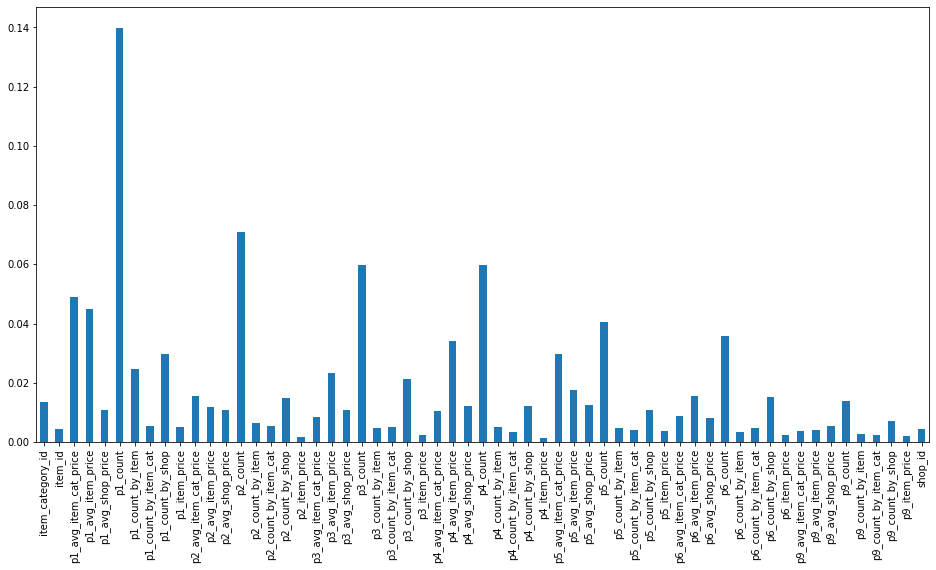

In [143]:

pd.Series(rfr.feature_importances_, index=X_train.columns).plot.bar(figsize=(16, 8))

### LightGBM

In [145]:
import lightgbm as lgb

In [170]:
lgb_model = lgb.LGBMRegressor(silent=False)

categorical_features = ['shop_id', 'item_id', 'item_category_id']
train_lgb_data = lgb.Dataset(X_train, label=Y_train, categorical_feature=categorical_features)

In [171]:
params = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'num_leaves': 900,
    'n_estimators': 100,
    'metric': 'mse'
    
}
lgb_model = lgb.train(params, train_lgb_data, )



/usr/local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.418444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18031
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 59
[LightGBM] [Info] Start training from score -0.135977


In [174]:

prediction = lgb_model.predict(X_val, categorical_feature=categorical_features)
prediction = inverse_scaling(prediction, 'count')

In [175]:
prediction

array([1.74625155, 2.21635633, 2.13354049, ..., 1.00001258, 1.00001258,
       1.00001258])

In [176]:
prediction = lgb_model.predict(X_val, categorical_feature=categorical_features)
prediction = inverse_scaling(prediction, 'count')
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    1.385056
r2      0.600401
dtype: float64

In [187]:
params = {
    'max_depth': [16, 64,  -1],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [16, 50, 100,],
    'n_estimators': [40, 100],
    'subsample': [1],
    'subsample_freq': [1],
    'metric': ['mse']
}

def score_func(y_true, y_pred):
    y_true = inverse_scaling(y_true, 'count')
    y_pred = inverse_scaling(y_pred, 'count')
    return mean_squared_error(y_true, y_pred, squared=False)

lgb_model = lgb.LGBMRegressor(silent=False)
gs = GridSearchCV(lgb_model,
                  param_grid=params,
                  cv=5,
                  n_jobs=-1,
                  verbose=10,
                  scoring=make_scorer(score_func, greater_is_better=False)
                 )


In [188]:
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 55

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.548128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13264
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 59
[LightGBM] [Info] Start training from score -0.135977


GridSearchCV(cv=5, estimator=LGBMRegressor(silent=False), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [16, 64, -1], 'metric': ['mse'],
                         'n_estimators': [40, 100], 'num_leaves': [16, 50, 100],
                         'subsample': [1], 'subsample_freq': [1]},
             scoring=make_scorer(score_func, greater_is_better=False),
             verbose=10)

In [190]:
gs.best_estimator_

LGBMRegressor(max_depth=64, metric='mse', num_leaves=50, silent=False,
              subsample=1, subsample_freq=1)

In [196]:
best_param = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').iloc[0]['params']
best_param

{'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'mse',
 'n_estimators': 100,
 'num_leaves': 50,
 'subsample': 1,
 'subsample_freq': 1}

In [189]:
import joblib
joblib.dump(gs, 'lgb_gridsearch.pickle')

['lgb_gridsearch.pickle']

In [199]:
categorical_features = ['shop_id', 'item_id', 'item_category_id']
train_lgb_data = lgb.Dataset(X_train, label=Y_train, categorical_feature=categorical_features)
lgb_model = lgb.train(best_param, train_lgb_data, )


/usr/local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.416888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18031
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 59
[LightGBM] [Info] Start training from score -0.135977


In [200]:
prediction = lgb_model.predict(X_val, categorical_feature=categorical_features)
prediction = inverse_scaling(prediction, 'count')
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    1.376958
r2      0.605059
dtype: float64

<AxesSubplot:>

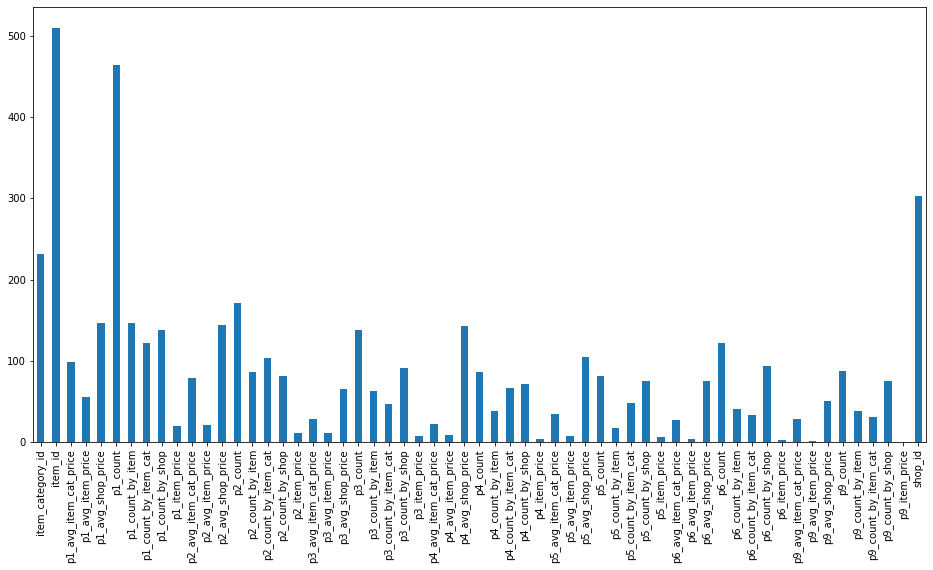

In [201]:

pd.Series(lgb_model.feature_importance(), index=X_train.columns).plot.bar(figsize=(16, 8))



### Predict

In [78]:
test_lookback_steps = [0, 1, 2, 4]
test_block = data['date_block_num'].max()
test_data = data[data['date_block_num'] >= test_block - max(test_lookback_steps)]
test_data = generate_past_features(test_data, test_lookback_steps)
test_data = test_data[test_data['date_block_num'] == test_block]
test_data = test_df.merge(test_data, how='left', on=['shop_id', 'item_id'])

100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


In [79]:
test_data

,ID,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,...,count_by_shop_p2,item_price_p2,avg_item_cat_price_p4,avg_item_price_p4,avg_shop_price_p4,count_p4,count_by_item_p4,count_by_item_cat_p4,count_by_shop_p4,item_price_p4
0,0,5,5037,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-0.360674,0.055993,0.316421,0.277872,0.064045,-0.150189,0.101107,-0.098123,-0.609183,0.375209
1,1,5,5320,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
2,2,5,5233,33,0.183616,-0.150189,19.0,-0.488361,-0.092942,-0.366726,...,-0.360674,-0.199571,0.316421,-0.165653,0.064045,-0.061612,0.148704,-0.098123,-0.609183,-0.199571
3,3,5,5232,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-0.360674,-0.199571,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
4,4,5,5268,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,33,-0.518894,-0.150189,55.0,-0.727945,-0.239394,0.919123,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
214196,214196,45,16188,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
214197,214197,45,15757,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
214198,214198,45,19648,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120


In [80]:
test_data

,ID,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,...,count_by_shop_p2,item_price_p2,avg_item_cat_price_p4,avg_item_price_p4,avg_shop_price_p4,count_p4,count_by_item_p4,count_by_item_cat_p4,count_by_shop_p4,item_price_p4
0,0,5,5037,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-0.360674,0.055993,0.316421,0.277872,0.064045,-0.150189,0.101107,-0.098123,-0.609183,0.375209
1,1,5,5320,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
2,2,5,5233,33,0.183616,-0.150189,19.0,-0.488361,-0.092942,-0.366726,...,-0.360674,-0.199571,0.316421,-0.165653,0.064045,-0.061612,0.148704,-0.098123,-0.609183,-0.199571
3,3,5,5232,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-0.360674,-0.199571,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
4,4,5,5268,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,33,-0.518894,-0.150189,55.0,-0.727945,-0.239394,0.919123,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
214196,214196,45,16188,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
214197,214197,45,15757,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120
214198,214198,45,19648,33,-0.582120,-0.150189,84.0,-1.195444,-0.235733,-1.300964,...,-1.195444,-0.582120,-0.628308,-0.579524,-4.595317,-0.150189,-0.235733,-1.300964,-1.195444,-0.582120


In [84]:
target_col = 'count'
feature_cols = list(test_data.columns.difference(
     [target_col, 'ID', 'date_block_num', 'item_price', 'count_by_shop', 'count_by_item', 'count_by_item_cat', 'avg_shop_price', 'avg_item_price', 'avg_item_cat_price']))
X_test = test_data[feature_cols].values

In [88]:
mean, var = scaler_params.loc['count'].tolist()

prediction = rfr.predict(X_test) * np.sqrt(var) + mean



In [99]:
submission_df = pd.DataFrame(np.array([test_data['ID'].values, prediction]).T,
                             columns=['ID', 'item_cnt_month'], )
submission_df['ID'] = submission_df['ID'].astype(int)
submission_df

,ID,item_cnt_month
0,0,1.054182
1,1,1.009042
2,2,2.054265
3,3,1.008879
4,4,1.009034
...,...,...
214195,214195,1.322249
214196,214196,1.006459
214197,214197,1.006459
214198,214198,1.006597


In [101]:
submission_df.to_csv('outputv1.csv', index=False)